In [1]:
import requests
import os
import zipfile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors

/Users/helenarusso/opt/miniconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Skin (Supplementary Figure 3h)

In [2]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = '5f30dc8527bb456190daf2e772bf399d'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../metadata_body_decomposition.txt', sep='\t')
column_interest = 'ATTRIBUTE_ADDGroup' #this is the column in the metadata table we will work with
sample_type = 'Skin' 

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [3]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', 'ATTRIBUTE_SampleType', column_interest]], 
                                  on='filename', how='left')
#keep skin
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_SampleType'] == sample_type]

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)

#delete last column
ftable_filtered_merged = ftable_filtered_merged.drop(ftable_filtered_merged.columns[-1], axis=1)


In [4]:
#let's create differenf dataframes for each stage of decomposition
early_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'early']
active_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'active']
advanced_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'advanced']
day0_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'Day0']

In [36]:
#now we need to create a dictionary with colors for each headgroup

features = [feature for feature in ftable_filtered_merged.columns if feature.startswith('MS')]

ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['Head'] = ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]

#let's create a colormap to be used
colors = [plt.cm.tab20(i) for i in range(15)]
cmap=matplotlib.colors.ListedColormap(colors)
color_dict = {'Tyramine': '#66c2a5',
              'Leucine': '#fc8d62',
              'Tyrosine': '#8da0cb',
              'GABA': '#ffd92f',
              'Putrescine': '#e5c494',
              '2': '#e78ac3',
              'Cadaverine': '#a6d854',
              'Amylamine': '#b3b3b3',
              'Glutamic acid': '#1f78b4',
              'Valine': '#fdbf6f',
              'Histamine': '#33a02c',
              'Spermidine': '#e31a1c',
              'Phenylalanine': '#fb9a99',
              'Alanine/Sarcosine': '#cab2d6',
              'Histidine': '#6a3d9a'}

# color_dict
ms_features['Color'] = ms_features['Head'].map(color_dict)


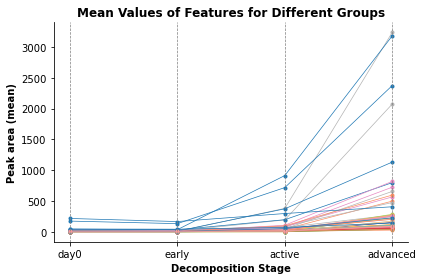

In [37]:
#calculateing mean for each headgroup
early_mean = early_df[features].mean()
active_mean = active_df[features].mean()
advanced_mean = advanced_df[features].mean()
day0_mean = day0_df[features].mean()

#create a dataframe to store the mean values
means_df = pd.DataFrame({
    'day0': day0_mean,
    'early': early_mean,
    'active': active_mean,
    'advanced': advanced_mean,
}).T

# Plot the means
fig, ax = plt.subplots(figsize=(6, 4))

# for getting the colors
colors = ms_features[['MS_#Scan#', 'Color']].set_index('MS_#Scan#').to_dict()['Color']

for column in means_df.columns:
    ax.plot(means_df[column], label=ms_features['Compound_Name_simplified'][ms_features['MS_#Scan#'] == column].values[0],
            color=colors.get(column, 'black'),
           marker='o', markersize=3, linewidth=0.7)

# Set the labels and title
ax.set_xlabel('Decomposition Stage', weight='bold')
ax.set_ylabel('Peak area (mean)', weight='bold')
ax.set_title('Mean Values of Features for Different Groups', weight='bold')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#add dashed lines in each stage
ax.axvline(x='early', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='active', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='advanced', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='day0', color='gray', linestyle='--', linewidth=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('/.../Supplementary_Figure_3h.pdf')
plt.show()


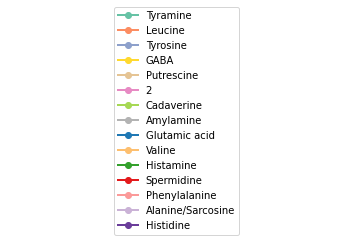

In [38]:
# Create a new figure for the legend
handles = [plt.Line2D([0], [0], color=color, marker='o', lw=2) for color in color_dict.values()]
labels = list(color_dict.keys())
fig_legend, ax_legend = plt.subplots(figsize=(5, 2))  # Adjust the size as needed
ax_legend.legend(handles, labels, loc='center')
ax_legend.axis('off')
plt.tight_layout()

plt.savefig('/.../Supplementary_Figure_3h_legend.pdf')            

# Soil (Supplementary Figure 3i)

In [40]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = '5f30dc8527bb456190daf2e772bf399d'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../metadata_body_decomposition.txt', sep='\t')
column_interest = 'ATTRIBUTE_ADDGroup' #this is the column in the metadata table we will work with
sample_type = 'Soil' 

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [41]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', 'ATTRIBUTE_SampleType', column_interest]], 
                                  on='filename', how='left')
#keep skin
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_SampleType'] == sample_type]

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)

#delete last column
ftable_filtered_merged = ftable_filtered_merged.drop(ftable_filtered_merged.columns[-1], axis=1)


In [42]:
#let's create differenf dataframes for each stage of decomposition
early_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'early']
active_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'active']
advanced_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'advanced']
day0_df = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_ADDGroup'] == 'Day0']

In [43]:
#now we need to create a dictionary with colors for each headgroup

features = [feature for feature in ftable_filtered_merged.columns if feature.startswith('MS')]

ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['Head'] = ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]

#let's create a colormap to be used
colors = [plt.cm.tab20(i) for i in range(15)]
cmap=matplotlib.colors.ListedColormap(colors)
color_dict = {'Tyramine': '#66c2a5',
              'Leucine': '#fc8d62',
              'Tyrosine': '#8da0cb',
              'GABA': '#ffd92f',
              'Putrescine': '#e5c494',
              '2': '#e78ac3',
              'Cadaverine': '#a6d854',
              'Amylamine': '#b3b3b3',
              'Glutamic acid': '#1f78b4',
              'Valine': '#fdbf6f',
              'Histamine': '#33a02c',
              'Spermidine': '#e31a1c',
              'Phenylalanine': '#fb9a99',
              'Alanine/Sarcosine': '#cab2d6',
              'Histidine': '#6a3d9a'}

# color_dict
ms_features['Color'] = ms_features['Head'].map(color_dict)


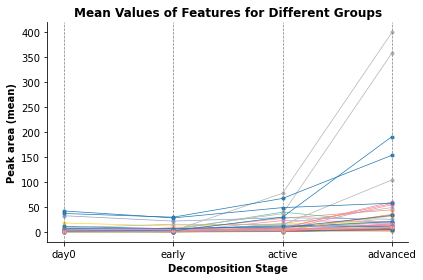

In [44]:
#calculateing mean for each headgroup
early_mean = early_df[features].mean()
active_mean = active_df[features].mean()
advanced_mean = advanced_df[features].mean()
day0_mean = day0_df[features].mean()

#create a dataframe to store the mean values
means_df = pd.DataFrame({
    'day0': day0_mean,
    'early': early_mean,
    'active': active_mean,
    'advanced': advanced_mean,
}).T

# Plot the means
fig, ax = plt.subplots(figsize=(6, 4))

# for getting the colors
colors = ms_features[['MS_#Scan#', 'Color']].set_index('MS_#Scan#').to_dict()['Color']

for column in means_df.columns:
    ax.plot(means_df[column], label=ms_features['Compound_Name_simplified'][ms_features['MS_#Scan#'] == column].values[0],
            color=colors.get(column, 'black'),
           marker='o', markersize=3, linewidth=0.7)

# Set the labels and title
ax.set_xlabel('Decomposition Stage', weight='bold')
ax.set_ylabel('Peak area (mean)', weight='bold')
ax.set_title('Mean Values of Features for Different Groups', weight='bold')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#add dashed lines in each stage
ax.axvline(x='early', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='active', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='advanced', color='gray', linestyle='--', linewidth=0.7)
ax.axvline(x='day0', color='gray', linestyle='--', linewidth=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('/.../Supplementary_Figure_3i.pdf')
plt.show()


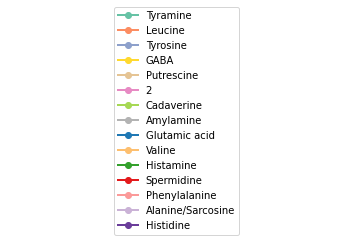

In [45]:
# Create a new figure for the legend
handles = [plt.Line2D([0], [0], color=color, marker='o', lw=2) for color in color_dict.values()]
labels = list(color_dict.keys())
fig_legend, ax_legend = plt.subplots(figsize=(5, 2))  # Adjust the size as needed
ax_legend.legend(handles, labels, loc='center')
ax_legend.axis('off')
plt.tight_layout()

plt.savefig('/.../Supplementary_Figure_3i_legend.pdf')
            